# Imputation

In [169]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, \
                            recall_score, roc_auc_score

Let's load in the new packages for this notebook.

In [170]:
from sklearn.impute import SimpleImputer


Let's load in and split our dataset.

We're going to undertake some of the steps from the `data_preprocessing_and_eda.ipynb` file.

In [171]:
try:
    data = pd.read_csv("data/raw_data.csv")

except FileNotFoundError:

    # Download raw data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/train.csv'

    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'raw_data.csv', index=False)

print(f"Total number of rows in raw dataset: {len(data)}")


Total number of rows in raw dataset: 891


In [172]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [173]:
data['SibSp'].value_counts(dropna=False)

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [174]:
###############################
# Replace unclear data values #
###############################
embarked_lookup = {
    'S': 'Southampton',
    'C':  'Cherbourg',
    'Q': 'Queenstown'
}

# Note that 'get' defaults to 'None' if the key doesn't appear in the dictionary lookup.
data['Embarked'] = data['Embarked'].apply(lambda row_value: embarked_lookup.get(row_value))

data['Embarked'].value_counts(dropna=False)

Southampton    644
Cherbourg      168
Queenstown      77
None             2
Name: Embarked, dtype: int64

In [175]:
#######################
# One hot encoding    #
#######################
# here we've asked for an additional column when no value is recorded for the embarkation point
one_hot = pd.get_dummies(data['Embarked'], prefix='Embarked', dummy_na=True).astype('int')
# Drop the column as it is now encoded
data = data.drop('Embarked', axis = 1)
# Join the encoded df
data = data.join(one_hot, how="left")


We can now just confirm that the number of people missing agree with our dataset from before.

In [176]:
data.loc[:, data.columns.str.startswith('Embarked')].sum(axis=0)

Embarked_Cherbourg      168
Embarked_Queenstown      77
Embarked_Southampton    644
Embarked_nan              2
dtype: int64

Now let's deal with our remaining preprocessing steps.

Notice that here we don't do anything to values that are neither male nor female so they will remain as their original value.

From our initial checks, we know that in this case no values were missing in the `Sex` column anyway.

In [177]:
#######################
# Dichotomous columns #
#######################
data['Sex'].replace('male', 1, inplace=True)
data['Sex'].replace('female', 0, inplace=True)
data = data.rename(columns={'Sex': 'IsMale'})

Now let's tidy up and display our final output.

In [178]:
#####################################
# Tidying up remaining column names #
#####################################
data = data.drop(columns=['Name', 'Ticket', 'Cabin'])
data = data.rename(columns={'Embarked_nan':'Embarked_Unknown'})

data.head()

,PassengerId,Survived,Pclass,IsMale,Age,SibSp,Parch,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Embarked_Unknown
0,1,0,3,1,22.0,1,0,7.2500,0,0,1,0
1,2,1,1,0,38.0,1,0,71.2833,1,0,0,0
2,3,1,3,0,26.0,0,0,7.9250,0,0,1,0
3,4,1,1,0,35.0,1,0,53.1000,0,0,1,0
4,5,0,3,1,35.0,0,0,8.0500,0,0,1,0


Now let's get our data ready for machine learning. 

In [179]:
data = data.astype(float)

# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

feature_names = X.columns.tolist()

Finally, let's check we haven't lost or gained any rows!

(if we were automating this, we may turn this into a hard-coded test that will cause the notebook/script to fail if the dataset is no longer the same size as the original dataset).

In [180]:
print(f"Total number of rows in raw dataset: {len(data)}")

Total number of rows in raw dataset: 891


## Checking for Missing Values

Let's just remind ourselves of our columns and their missing data.

In [181]:
pd.DataFrame(
    (data.isna().mean()*100).round(2),
    columns=["Percentage of Values Missing"]
    )

,Percentage of Values Missing
Survived,0.00
Pclass,0.00
IsMale,0.00
Age,19.87
SibSp,0.00
Parch,0.00
Fare,0.00
Embarked_Cherbourg,0.00
Embarked_Queenstown,0.00
Embarked_Southampton,0.00


We could choose to impute the embarkation as well; however, in this case, as it's a low number of samples we will just choose to stick with that being unknown.  

## A note on the order of steps

To avoid *leakage* you should perform imputation steps *after* splitting your data into training and testing datasets.

In [182]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training Dataset Samples: {len(X_train)}")
print(f"Validation Dataset Samples: {len(X_validate)}")
print(f"Testing Dataset Samples: {len(X_test)}")

Training Dataset Samples: 569
Validation Dataset Samples: 143
Testing Dataset Samples: 179


This is why imputing categorical columns can complicate things slightly - you need to do the split, but then you will need to apply some transformations - like one-hot encoding - to each dataset separately.

Good use of functions can ensure this is a relatively painless process - but is not one we'll cover today. 

## Exploring the distribution prior to imputation

As we're just looking at age today, let's take a look at that column and some statistics.

In [183]:
X_train['Age'].mean()

28.99313043478261

In [184]:
X_train['Age'].median()

28.0

In [185]:
X_train['Age'].mode()

0    24.0
Name: Age, dtype: float64

<Axes: >

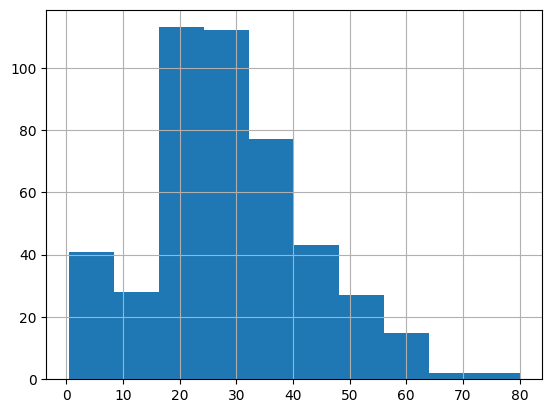

In [186]:
X_train['Age'].hist()

Let's find the missing values and pull them out so we can track how they change.

In [187]:
indices_missing_age = X_train[X_train['Age'].isna()].index
indices_missing_age

Int64Index([517, 792, 420,  95, 495, 384, 159, 301, 826, 274,
            ...
            468, 470,  64, 223, 564, 284, 888,  19, 295, 214],
           dtype='int64', length=109)

## Simple Imputation

### Mean Imputation

In [188]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_mean_imp = imp_mean.fit_transform(X_train)

X_train_mean_imp

array([[ 3.        ,  1.        , 28.99313043, ...,  1.        ,
         0.        ,  0.        ],
       [ 3.        ,  0.        , 28.99313043, ...,  0.        ,
         1.        ,  0.        ],
       [ 2.        ,  0.        , 33.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 2.        ,  1.        , 29.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 3.        ,  0.        , 27.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 3.        ,  1.        , 20.        , ...,  0.        ,
         1.        ,  0.        ]])

However, when we do this, we find that our output is now a numpy array instead of a dataframe. 

We can use the following notation to avoid this issue.

In [189]:
X_train_mean_imp = X_train.copy()
X_train_mean_imp.values[:] = SimpleImputer().fit_transform(X_train)
X_train_mean_imp

,Pclass,IsMale,Age,SibSp,Parch,Fare,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton,Embarked_Unknown
517,3.0,1.0,28.99313,0.0,0.0,24.1500,0.0,1.0,0.0,0.0
792,3.0,0.0,28.99313,8.0,2.0,69.5500,0.0,0.0,1.0,0.0
472,2.0,0.0,33.00000,1.0,2.0,27.7500,0.0,0.0,1.0,0.0
483,3.0,0.0,63.00000,0.0,0.0,9.5875,0.0,0.0,1.0,0.0
9,2.0,0.0,14.00000,1.0,0.0,30.0708,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
79,3.0,0.0,30.00000,0.0,0.0,12.4750,0.0,0.0,1.0,0.0
164,3.0,1.0,1.00000,4.0,1.0,39.6875,0.0,0.0,1.0,0.0
117,2.0,1.0,29.00000,1.0,0.0,21.0000,0.0,0.0,1.0,0.0
8,3.0,0.0,27.00000,0.0,2.0,11.1333,0.0,0.0,1.0,0.0


Let's see what this has done to our data distribution.

<Axes: >

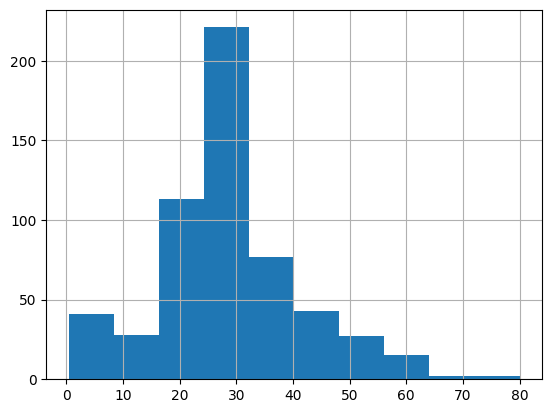

In [190]:
X_train_mean_imp['Age'].hist()

This looks quite different to our original distribution.

<Axes: >

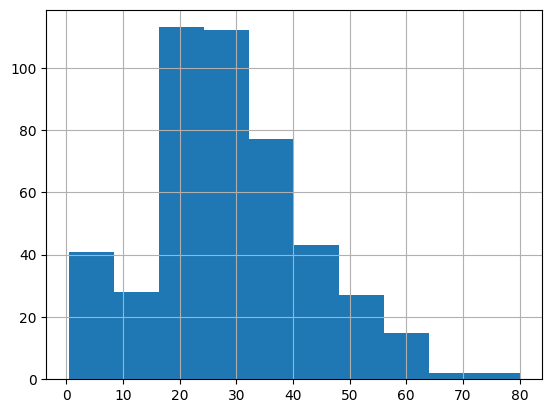

In [191]:
X_train['Age'].hist()

Let's look at the individual rows.

In [193]:
X_train_mean_imp.loc[X_train_mean_imp.index[indices_missing_age]]

IndexError: index 792 is out of bounds for axis 0 with size 569

We could turn this into a function to make it quicker to carry out.

In [ ]:
# def impute(df):
#     X_train_mean_imp.values[:] = SimpleImputer().fit_transform(X_train)